In [82]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy
from scipy.interpolate import interp1d
import skimage
from skimage import io, exposure, filters

from numpy.fft import fftshift, fft2, ifft2, fft, ifft
from numpy import real
from numpy import conj

%matplotlib notebook


In [83]:
def autocorrelation_2D(image):
    data = image-image.mean() 
    data = data / data.std()
    
    temp = real(fftshift(ifft2(fft2(data)*conj(fft2(data)))))
    temp = temp / (data.shape[0]*data.shape[1])
    
    return temp

def autocorrelation_1D(image, ax):
    # This function computes a 1D correlation
    # of a 2D image. 
    # Input parameters:
    #    image -- a 2D numpy array
    #    ax -- the axis to perform the autocorrelation
    #
    # Note about which axes to use:
    #   for ax = 0: this will correlate things along the vertical direction when displayed using matshow
    #   for ax = 1: this will correlate along the horizontal direction when displayed using matshow
    
    means = image.mean(axis=ax)
    temp = np.tile(means, (image.shape[ax], 1))
    if ax==0:
        data = image - temp
    elif ax==1:
        data = image - temp.transpose()
    else:
        print("ax must be 0 or 1")
        return 0
    
    std_devs = data.std(axis=ax)
    #print("shape of std_devs: ", std_devs.shape) #for debugging purposes
    temp = np.tile(std_devs, (image.shape[ax],1))
    if ax==0:
        data = data / temp
    elif ax==1:
        data = data / temp.transpose()
        
    temp = fftshift(ifft(fft(data,axis=ax)*conj(fft(data,axis=ax)),axis=ax),axes=ax)
    temp = real(temp) / data.shape[ax]
       
    if ax==0:
        corr = temp.sum(axis=1)/temp.shape[1]
        return corr[int(temp.shape[0]/2):]
    elif ax==1:
        corr = temp.sum(axis=0)/temp.shape[0]
        return corr[int(temp.shape[1]/2):]
    
def find_where_corr_at_half(corr, val=0.5):
    # This function will actually only find where the correlation function goes to 0.5
    # (which, if properly normalized, means that it dropped 50%) if the "val" is set
    # to 0.5 which is the default. However, you can change that to another value like
    # 0.2 or 1/e or something else. 
    f = interp1d(np.arange(0,len(corr)), corr, kind='linear', fill_value="extrapolate") #create interpolation function
    new_x = np.linspace(0, len(corr), 10*len(corr))  #new x-axis that is 10 times more sampled
    eval_at_new_x = f(new_x) #evaluate the interpolated function over the new range of x-values
    min_index = np.argmin(abs(eval_at_new_x-val)) #find where that is closest to "val" 
    return new_x[min_index]

def autocorr_decay_value(images, background, framenum, decay_fraction=0.7):
    filtered_image = 1.0 * images[framenum] - background
    corr2d = autocorrelation_2D(filtered_image)

    acorr0_from2d = corr2d[int(filtered_image.shape[0]/2),int(filtered_image.shape[1]/2):]
    acorr1_from2d = corr2d[int(filtered_image.shape[0]/2):,int(filtered_image.shape[1]/2)]
    where_autocorr_decay_0 = find_where_corr_at_half(acorr0_from2d, val=decay_fraction)
    where_autocorr_decay_1 = find_where_corr_at_half(acorr1_from2d, val=decay_fraction)
    return (where_autocorr_decay_0, where_autocorr_decay_1)

In [86]:
all_data = {}

Set the directory for where the data is below.

In [173]:
drive_letter = "Y"
data_dir = drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\03_Flow_sweep_31Deg_10x\\"
sub_dir_number = 7
sub_dir = "03_Flow_sweep_31Deg_10x_%i" % sub_dir_number
data_file = "\\" + sub_dir + "_MMStack_Default.ome.tif"
full_path = data_dir+sub_dir+data_file

#Enter the correct pixel size below: 
pixel_size = 1.0

experiment_number = 3
shear_rate = 15

dictionary_entry = '2021-08-10 - 0%i - 0%i - %iHz' % (experiment_number, sub_dir_number, shear_rate)
print(dictionary_entry)

all_data[dictionary_entry] = {}
all_data[dictionary_entry]['path'] = full_path
all_data[dictionary_entry]['shear rate'] = shear_rate

2021-08-10 - 03 - 07 - 15Hz


In [153]:
images = skimage.io.imread(data_dir+sub_dir+data_file)
print("Number of frames in %s: %s" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

##Creating background
mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=120)

Number of frames in \03_Flow_sweep_31Deg_10x_7_MMStack_Default.ome.tif: 2000
Dimensions of an image is 492 by 656 pixels.


In [154]:
all_horizontal_lengthscales = np.zeros((im.shape[0]))
all_vertical_lengthscales = np.zeros_like(all_horizontal_lengthscales)
for i in range(0,im.shape[0]):
    all_horizontal_lengthscales[i], all_vertical_lengthscales[i] = autocorr_decay_value(images, background, i, decay_fraction=0.7)
    
all_data[dictionary_entry]['all_horizontal_lengthscales'] = all_horizontal_lengthscales
all_data[dictionary_entry]['all_vertical_lengthscales'] = all_vertical_lengthscales
all_data[dictionary_entry]['mean_horizontal_lengthscale'] = all_horizontal_lengthscales.mean()
all_data[dictionary_entry]['mean_vertical_lengthscale'] = all_vertical_lengthscales.mean()

In [155]:
all_data.keys()

dict_keys(['2021-08-10 - 04 - 01 - 1Hz', '2021-08-10 - 04 - 02 - 1Hz', '2021-08-10 - 04 - 03 - 2Hz', '2021-08-10 - 04 - 04 - 2Hz', '2021-08-10 - 04 - 05 - 3Hz', '2021-08-10 - 04 - 06 - 3Hz', '2021-08-10 - 04 - 09 - 4Hz', '2021-08-10 - 04 - 010 - 4Hz', '2021-08-10 - 04 - 011 - 5Hz', '2021-08-10 - 04 - 012 - 5Hz', '2021-08-10 - 03 - 01 - 1Hz', '2021-08-10 - 03 - 02 - 1Hz', '2021-08-10 - 03 - 03 - 5Hz', '2021-08-10 - 03 - 05 - 5Hz', '2021-08-10 - 03 - 06 - 15Hz', '2021-08-10 - 03 - 07 - 15Hz'])

In [167]:
shear_rates = []
horizontal_lengths = []
vertical_lengths = []

for i,key in enumerate(all_data.keys()):
    shear_rates.append(all_data[key]['shear rate'])
    horizontal_lengths.append(all_data[key]['mean_horizontal_lengthscale'])
    vertical_lengths.append(all_data[key]['mean_vertical_lengthscale'])
    
shear_rates = np.array(shear_rates)
horizontal_lengths = np.array(horizontal_lengths)
vertical_lengths = np.array(vertical_lengths)

shear_rates_new = np.array([1,2,3,4,5,15])
avg_h_lengths = np.zeros_like(shear_rates_new)
avg_v_lengths = np.zeros_like(shear_rates_new)
for i in range(len(shear_rates_new)):
    w = np.where(shear_rates == shear_rates_new[i])
    avg_h_lengths[i] = horizontal_lengths[w].mean()
    avg_v_lengths[i] = vertical_lengths[w].mean()

<IPython.core.display.Javascript object>


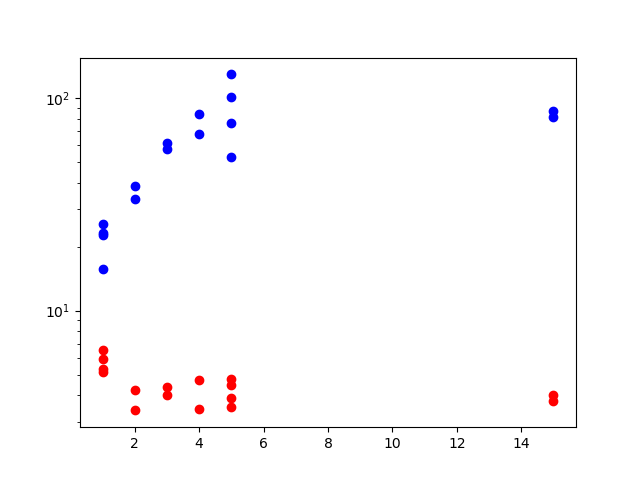

<IPython.core.display.Javascript object>


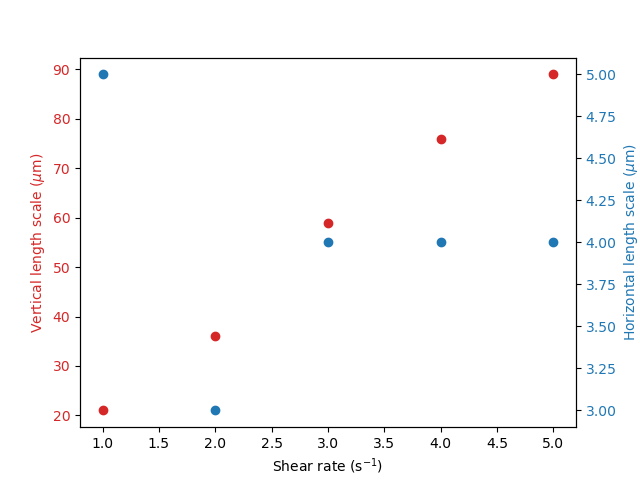

In [174]:
plt.figure()
plt.semilogy(shear_rates, horizontal_lengths, 'ro', label="")
plt.plot(shear_rates, vertical_lengths, 'bo')

###############################################################################

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Shear rate (s$^{-1}$)')
ax1.set_ylabel('Vertical length scale ($\mu$m)', color=color)
ax1.plot(shear_rates_new[:-1], pixel_size*avg_v_lengths[:-1], 'o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Horizontal length scale ($\mu$m)', color=color)  # we already handled the x-label with ax1
ax2.plot(shear_rates_new[:-1], pixel_size*avg_h_lengths[:-1], 'o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [172]:
f = open(drive_letter+":\\Dennis Terwilliger\\Data\\2021-08-10\\Autocorr_lengths_decayto70_03and04.p",'wb')
pickle.dump(all_data, f)
f.close()